In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data.csv')

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 20.9 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer
bert_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_name,
 add_special_tokens=True,
 do_lower_case=False,
 max_length=150,
 pad_to_max_length=True,
 return_attention_mask=True,
 return_token_type_ids=True                                         
 )

In [ ]:
data['label']=data['label'].replace({'FAKE':1, 'REAL': 0})

In [ ]:
def bert_encoder(txt):
 encoded = tokenizer.encode_plus(txt, add_special_tokens=True, max_length=150, pad_to_max_length=True, return_attention_mask=True, return_token_type_ids=True)
 return encoded['input_ids'], encoded['token_type_ids'], encoded['attention_mask']

In [ ]:
import tensorflow as tf
bert_train = [bert_encoder(text) for text in data['text']]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import numpy as np
bert_lbl = data['label']
bert_train = np.array(bert_train)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(bert_train, bert_lbl, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)

(5068, 3, 150) (5068,)


In [ ]:
tr_reviews, tr_segments, tr_masks = np.split(x_train, 3, axis=1)
val_reviews, val_segments, val_masks = np.split(x_val, 3, axis=1)

In [ ]:
tr_reviews = tr_reviews.squeeze()
tr_segments = tr_segments.squeeze()
tr_masks = tr_masks.squeeze()
val_reviews = val_reviews.squeeze()
val_segments = val_segments.squeeze()
val_masks = val_masks.squeeze()

In [ ]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
 return {"input_ids": input_ids,
 "attention_mask": attention_masks,
 "token_type_ids": token_type_ids},y

In [ ]:
import tensorflow as tf
train_ds = tf.data.Dataset.from_tensor_slices((tr_reviews,tr_masks, tr_segments, y_train)).map(example_to_features).shuffle(100).batch(16)
valid_ds = tf.data.Dataset.from_tensor_slices((val_reviews,val_masks, val_segments, y_val)).map(example_to_features).shuffle(100).batch(16)

In [ ]:
from transformers import TFBertModel
bert_name = 'bert-base-cased'
bert = TFBertModel.from_pretrained(bert_name)
bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
max_seq_len = 150
inp_ids = tf.keras.layers.Input((max_seq_len,), dtype=tf.int64, name="input_ids")
att_mask = tf.keras.layers.Input((max_seq_len,), dtype=tf.int64, name="attention_mask")
seg_ids = tf.keras.layers.Input((max_seq_len,), dtype=tf.int64, name="token_type_ids")

In [ ]:
inp_dict = {"input_ids": inp_ids,
 "attention_mask": att_mask,
 "token_type_ids": seg_ids}
outputs = bert(inp_dict)

In [ ]:
x = tf.keras.layers.Dropout(0.2)(outputs[1])
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
custom_model = tf.keras.models.Model(inputs=inp_dict, outputs=x)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
custom_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
custom_history = custom_model.fit(train_ds, epochs=5, validation_data=valid_ds)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


317/317 [==============================] - 195s 569ms/step - loss: 0.2211 - accuracy: 0.9112 - val_loss: 0.0965 - val_accuracy: 0.9621
Epoch 2/5
317/317 [==============================] - 177s 559ms/step - loss: 0.0657 - accuracy: 0.9765 - val_loss: 0.0911 - val_accuracy: 0.9732
Epoch 3/5
317/317 [==============================] - 178s 561ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.0988 - val_accuracy: 0.9747
Epoch 4/5
317/317 [==============================] - 175s 553ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.1283 - val_accuracy: 0.9653
Epoch 5/5
317/317 [==============================] - 177s 559ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.1299 - val_accuracy: 0.9692


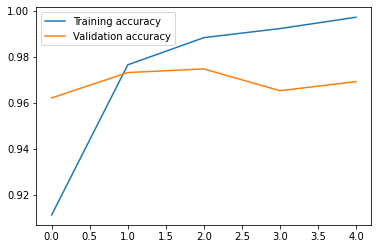

In [ ]:
import matplotlib.pyplot as plt
acc = custom_history.history['accuracy']
val_acc = custom_history.history['val_accuracy']
epochs = len(acc)
plt.plot(range(epochs),acc, label='Training accuracy')
plt.plot(range(epochs),val_acc,label='Validation accuracy')
plt.legend()
plt.show()

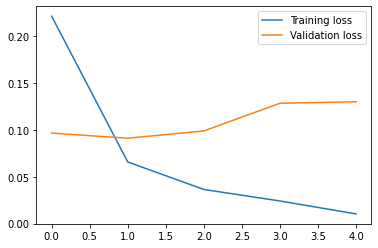

In [ ]:
loss = custom_history.history['loss']
val_loss = custom_history.history['val_loss']
plt.plot(range(epochs),loss, label='Training loss')
plt.plot(range(epochs),val_loss,label='Validation loss')
plt.legend()
plt.show()

In [ ]:
def get_val_x(input_ids,attention_masks,token_type_ids):
 return {"input_ids": input_ids,
 "attention_mask": attention_masks,
 "token_type_ids": token_type_ids}

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices((val_reviews,val_masks, val_segments)).map(get_val_x).batch(16)

In [ ]:
pred = custom_model.predict(valid_ds)

In [ ]:
pred

array([[9.9962246e-01],
       [9.9975580e-01],
       [9.9993992e-01],
       ...,
       [1.1638552e-03],
       [4.7239353e-04],
       [1.4259267e-03]], dtype=float32)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
print(classification_report(y_val, np.round(pred)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       639
           1       0.97      0.97      0.97       628

    accuracy                           0.97      1267
   macro avg       0.97      0.97      0.97      1267
weighted avg       0.97      0.97      0.97      1267

